# DATA PROCESSING IMPORTS

In [40]:
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

# DEEP LEARNING IMPORTS

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, 
                                     Dropout, BatchNormalization, GlobalAveragePooling2D,
                                     Activation, Input, Concatenate)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


# Scikit-learn IMPORTS

In [42]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, 
                            accuracy_score, precision_recall_fscore_support,
                            roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import label_binarize

# EXPLORE THE DATA

### READ THE DATA 

In [43]:
folder_path = '/kaggle/input/dataset'

file_names = os.listdir(folder_path)
print(f"Total files in dataset: {len(file_names)}")

numbers_outside = [
    int(re.match(r"^(\d+)", file).group(1)) 
    for file in file_names if re.match(r"^(\d+)", file)
]

unique_numbers_outside = sorted(set(numbers_outside))

df_unique = pd.DataFrame(unique_numbers_outside, columns=["Currency"])
print(df_unique)


Total files in dataset: 70542
   Currency
0         2
1         5
2        10
3        20
4        50
5       100
6       500
7      1000


### Count occurrences of each currency type

In [44]:
currency_types = []
for file in file_names:
    match = re.match(r"^(\d+)\s*\(", file)
    if match:
        currency_types.append(int(match.group(1)))

currency_counts = Counter(currency_types)

df_counts = pd.DataFrame(list(currency_counts.items()), 
                         columns=["Currency Type", "Count"])
df_counts = df_counts.sort_values(by="Currency Type")

print(df_counts)
print(f"Number of Classes: {len(df_counts)}")

   Currency Type  Count
4              2   5105
6              5   6389
1             10   8382
2             20  14188
7             50   9837
0            100   6999
3            500  11927
5           1000   7715
Number of Classes: 8


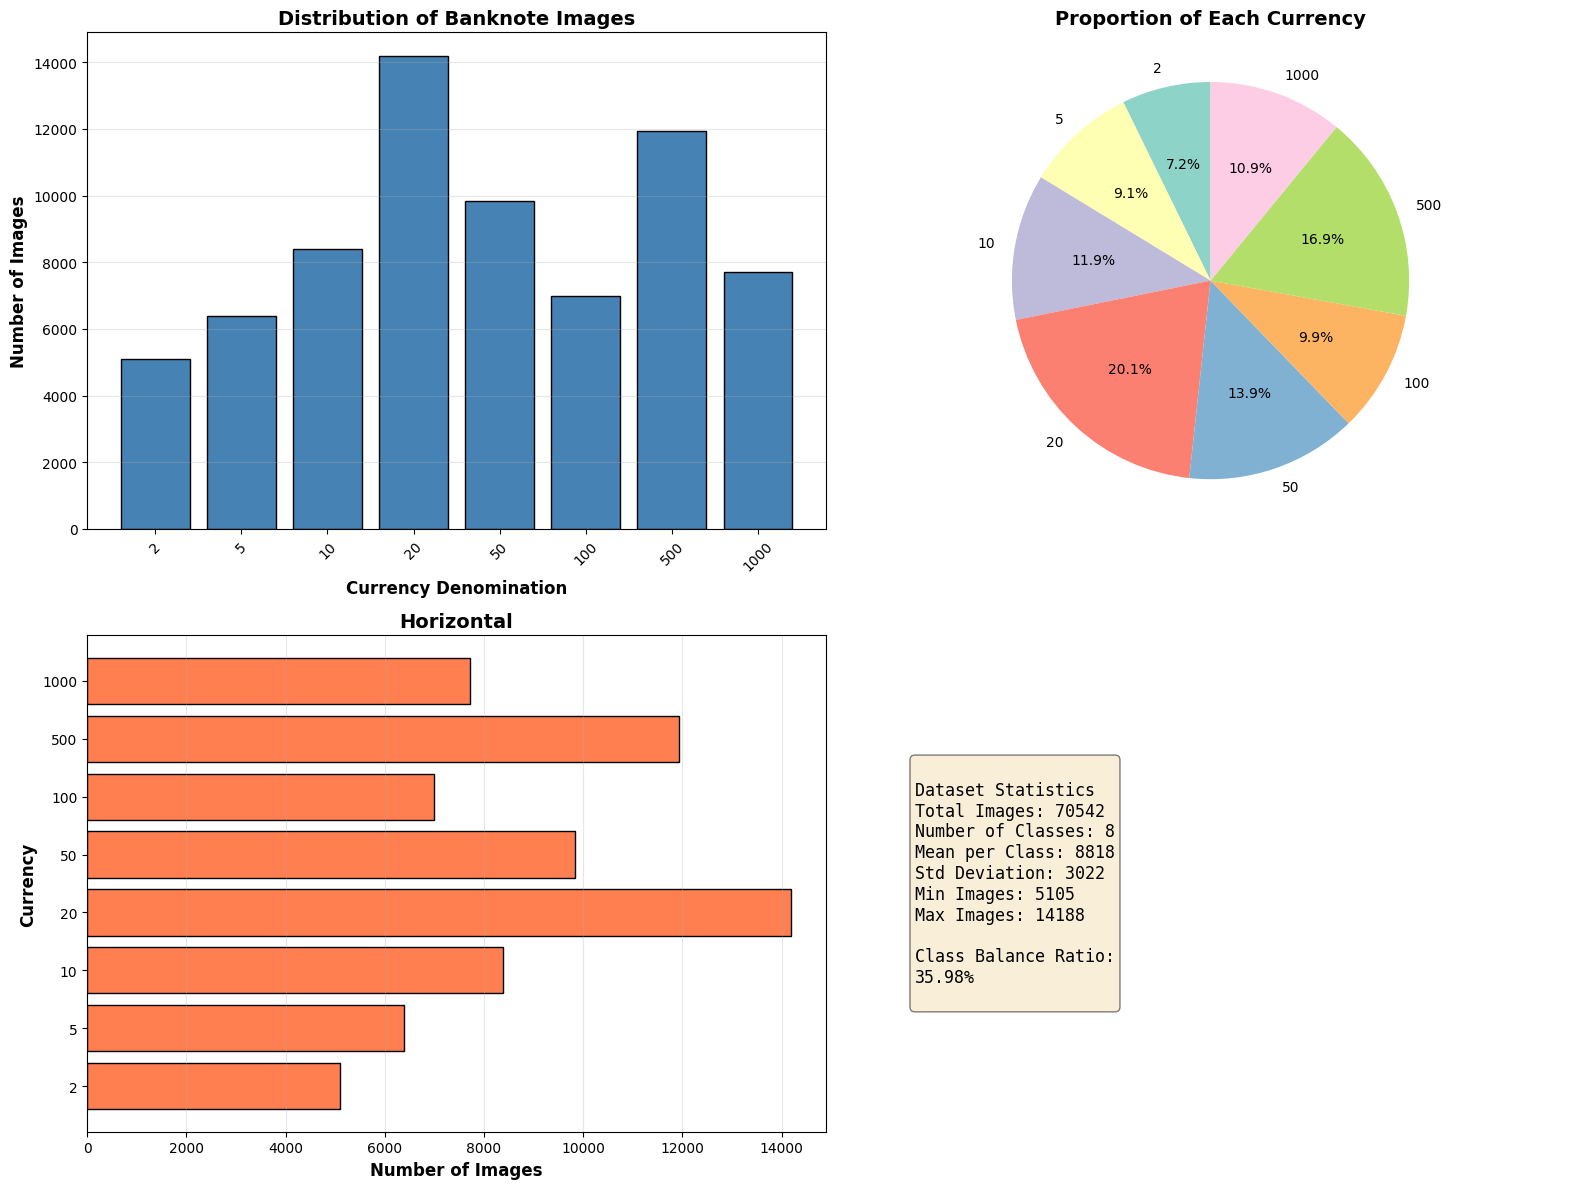

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].bar(df_counts['Currency Type'].astype(str), df_counts['Count'], 
               color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Currency Denomination', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Images', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Distribution of Banknote Images', 
                     fontsize=14, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

colors = plt.cm.Set3(range(len(df_counts)))
axes[0, 1].pie(df_counts['Count'], labels=df_counts['Currency Type'], 
               autopct='%1.1f%%', colors=colors, startangle=90)
axes[0, 1].set_title('Proportion of Each Currency', 
                     fontsize=14, fontweight='bold')

axes[1, 0].barh(df_counts['Currency Type'].astype(str), df_counts['Count'], 
                color='coral', edgecolor='black')
axes[1, 0].set_xlabel('Number of Images', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Currency', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Horizontal', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

stats_text = f"""
Dataset Statistics
Total Images: {df_counts['Count'].sum()}
Number of Classes: {len(df_counts)}
Mean per Class: {df_counts['Count'].mean():.0f}
Std Deviation: {df_counts['Count'].std():.0f}
Min Images: {df_counts['Count'].min()}
Max Images: {df_counts['Count'].max()}

Class Balance Ratio:
{(df_counts['Count'].min() / df_counts['Count'].max()):.2%}
"""
axes[1, 1].text(0.1, 0.5, stats_text, fontsize=12, family='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', 
                facecolor='wheat', alpha=0.5))
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

pip install sklearn


### Store images for each currency type

In [46]:
currency_images = defaultdict(list)

for file in file_names:
    match = re.match(r"^(\d+)\s*\(", file)
    if match:
        currency_type = int(match.group(1))
        currency_images[currency_type].append(file)

currency_image_lists = dict(currency_images)

for currency, images in sorted(currency_image_lists.items()):
    print(f"Currency {currency}: {len(images)} images")

Currency 2: 5105 images
Currency 5: 6389 images
Currency 10: 8382 images
Currency 20: 14188 images
Currency 50: 9837 images
Currency 100: 6999 images
Currency 500: 11927 images
Currency 1000: 7715 images


### Sample Images from Each Currency Denomination

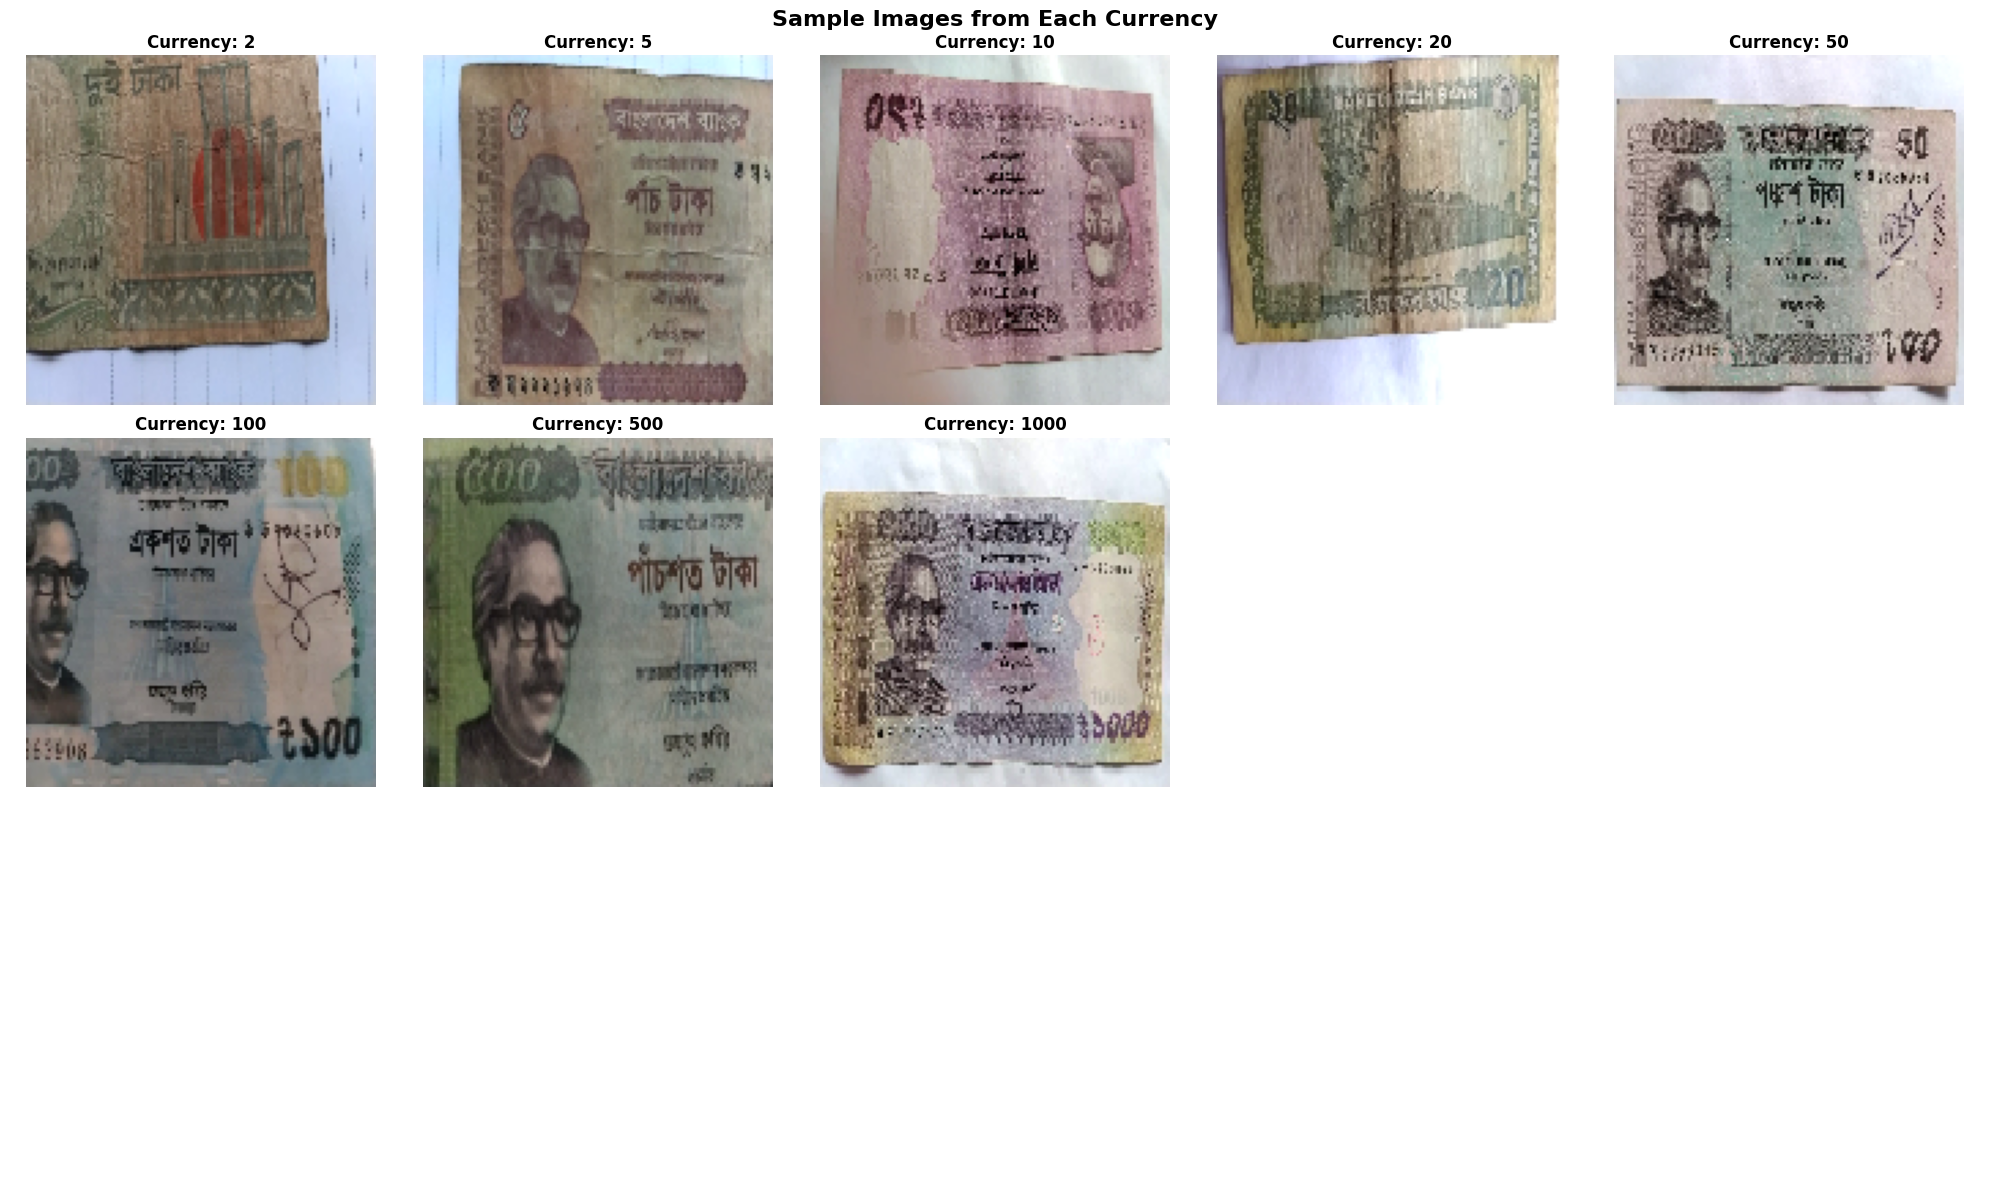

In [47]:
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.ravel()

idx = 0
for currency in sorted(currency_image_lists.keys()):
    if idx >= 15:
        break
    
    matching_images = currency_image_lists[currency]
    if matching_images:
        img_path = os.path.join(folder_path, matching_images[0])
        img = load_img(img_path, target_size=(128, 128))
        
        axes[idx].imshow(img)
        axes[idx].set_title(f'Currency: {currency}', fontsize=12, fontweight='bold')
        axes[idx].axis('off')
        idx += 1

for i in range(idx, 15):
    axes[i].axis('off')

plt.suptitle('Sample Images from Each Currency', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()


### Make Dataset balanced

In [48]:
limited_currency_image_lists = {}

for currency, images in currency_image_lists.items():
    if len(images) > 800:
        limited_currency_image_lists[currency] = random.sample(images, 800)
    else:
        limited_currency_image_lists[currency] = images

print("Balanced Dataset:")
for currency, images in sorted(limited_currency_image_lists.items()):
    print(f"Currency {currency}: {len(images)} images")

currency_image_lists = limited_currency_image_lists

Balanced Dataset:
Currency 2: 800 images
Currency 5: 800 images
Currency 10: 800 images
Currency 20: 800 images
Currency 50: 800 images
Currency 100: 800 images
Currency 500: 800 images
Currency 1000: 800 images


# DATA PREPROCESSING


### NORMALIZATION AND SHOW SOME STATISTICS

In [49]:
IMAGE_SIZE = (128, 128)

sample_images_data = []
sample_size = 50

for currency, file_list in currency_image_lists.items():
    for file_name in file_list[:sample_size]:
        img_path = os.path.join(folder_path, file_name)
        img = load_img(img_path, target_size=IMAGE_SIZE)
        img_array = img_to_array(img) / 255.0
        sample_images_data.append({
            'currency': currency,
            'mean': img_array.mean(),
            'std': img_array.std(),
            'min': img_array.min(),
            'max': img_array.max()
        })

df_img_stats = pd.DataFrame(sample_images_data)

print("\nImage Statistics:")
print(df_img_stats.groupby('currency').agg({
    'mean': ['mean', 'std'],
    'std': ['mean', 'std']
}).round(4))


Image Statistics:
            mean             std        
            mean     std    mean     std
currency                                
2         0.5209  0.0434  0.1897  0.0396
5         0.5383  0.0445  0.1730  0.0322
10        0.5934  0.0330  0.1684  0.0201
20        0.5550  0.0480  0.2070  0.0347
50        0.5334  0.0630  0.1460  0.0334
100       0.5737  0.0577  0.1952  0.0243
500       0.5599  0.0611  0.2027  0.0309
1000      0.5503  0.0821  0.1918  0.0250


### VISUALIZE Mean AND STD pixel VALUES

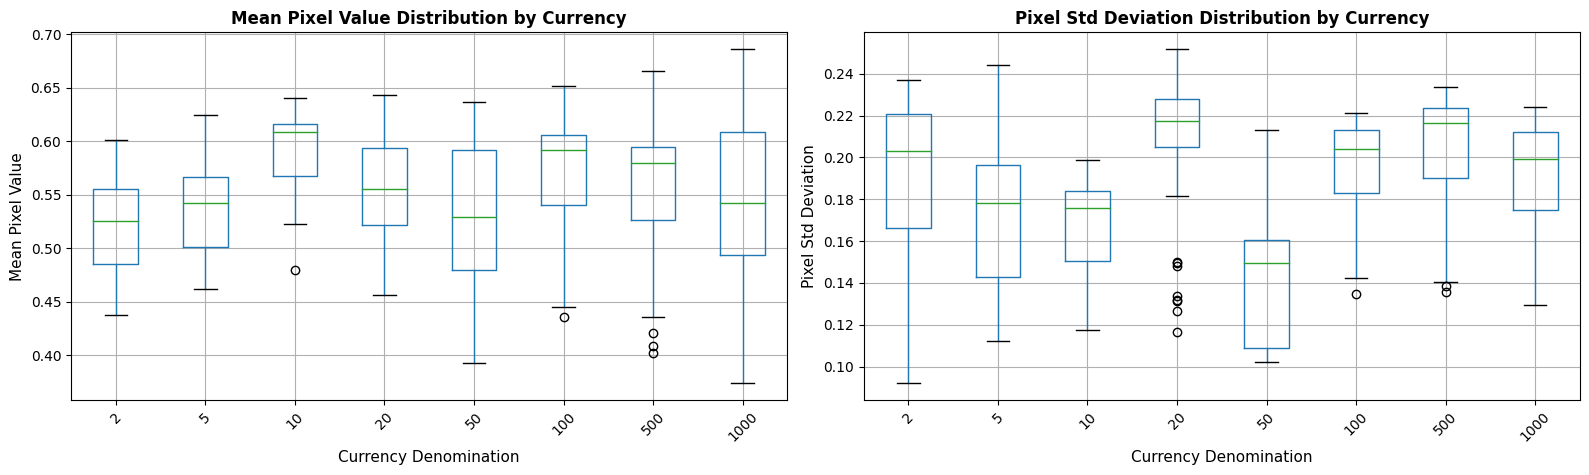

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

df_img_stats.boxplot(column='mean', by='currency', ax=axes[0])
axes[0].set_title('Mean Pixel Value Distribution by Currency', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Currency Denomination', fontsize=11)
axes[0].set_ylabel('Mean Pixel Value', fontsize=11)
plt.sca(axes[0])
plt.xticks(rotation=45)



df_img_stats.boxplot(column='std', by='currency', ax=axes[1])
axes[1].set_title('Pixel Std Deviation Distribution by Currency', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Currency Denomination', fontsize=11)
axes[1].set_ylabel('Pixel Std Deviation', fontsize=11)
plt.sca(axes[1])
plt.xticks(rotation=45)

plt.suptitle('')
plt.tight_layout()
plt.show()


# Load Complete Dataset

In [51]:
images = []
labels = []

for currency, file_list in currency_image_lists.items():
    for i, file_name in enumerate(file_list):
        if i % 500 == 0:
            print(f"Processing currency {currency}: {i}/{len(file_list)}")
        
        image_path = os.path.join(folder_path, file_name)
        image = load_img(image_path, target_size=IMAGE_SIZE)
        image_array = img_to_array(image) / 255.0
        
        images.append(image_array)
        labels.append(int(currency))

images = np.array(images)
labels = np.array(labels)

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Processing currency 100: 0/800
Processing currency 100: 500/800
Processing currency 10: 0/800
Processing currency 10: 500/800
Processing currency 20: 0/800
Processing currency 20: 500/800
Processing currency 500: 0/800
Processing currency 500: 500/800
Processing currency 2: 0/800
Processing currency 2: 500/800
Processing currency 1000: 0/800
Processing currency 1000: 500/800
Processing currency 5: 0/800
Processing currency 5: 500/800
Processing currency 50: 0/800
Processing currency 50: 500/800
Images shape: (6400, 128, 128, 3)
Labels shape: (6400,)


# Encoded labels shape

In [52]:
unique_currencies = sorted(np.unique(labels))
currency_to_idx = {curr: idx for idx, curr in enumerate(unique_currencies)}
idx_to_currency = {idx: curr for curr, idx in currency_to_idx.items()}

print("Class Mapping:")
for curr, idx in currency_to_idx.items():
    print(f"Currency {curr} ----> Class {idx}")

labels_encoded = np.array([currency_to_idx[label] for label in labels])

labels_categorical = to_categorical(labels_encoded)
num_classes = len(unique_currencies)

print(f"\nNumber of classes: {num_classes}")
print(f"Encoded labels shape: {labels_categorical.shape}")

Class Mapping:
Currency 2 ----> Class 0
Currency 5 ----> Class 1
Currency 10 ----> Class 2
Currency 20 ----> Class 3
Currency 50 ----> Class 4
Currency 100 ----> Class 5
Currency 500 ----> Class 6
Currency 1000 ----> Class 7

Number of classes: 8
Encoded labels shape: (6400, 8)


# SPLIT THE DATA --> TRAIN , TEST , VAL

In [53]:
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels_categorical, 
    test_size=0.3, 
    random_state=42,
    stratify=labels_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5, 
    random_state=42,
    stratify=np.argmax(y_temp, axis=1)
)

print(f"Training data: {X_train.shape[0]} images ({X_train.shape[0]/len(images)*100:.1f}%)")
print(f"Validation data: {X_val.shape[0]} images ({X_val.shape[0]/len(images)*100:.1f}%)")
print(f"Test data: {X_test.shape[0]} images ({X_test.shape[0]/len(images)*100:.1f}%)")

Training data: 4480 images (70.0%)
Validation data: 960 images (15.0%)
Test data: 960 images (15.0%)


# Train/Val/Test data distribution

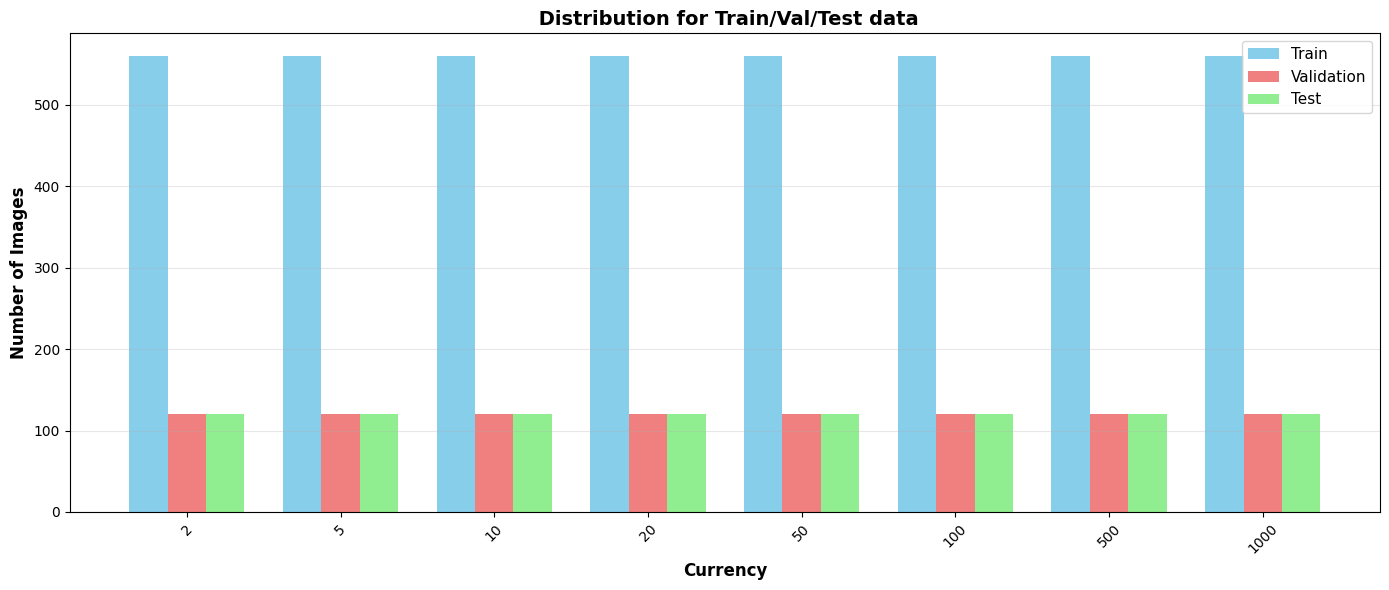

In [54]:
train_dist = pd.Series(np.argmax(y_train, axis=1)).value_counts().sort_index()
val_dist = pd.Series(np.argmax(y_val, axis=1)).value_counts().sort_index()
test_dist = pd.Series(np.argmax(y_test, axis=1)).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(unique_currencies))
width = 0.25

ax.bar(x - width, train_dist.values, width, label='Train', color='skyblue')
ax.bar(x, val_dist.values, width, label='Validation', color='lightcoral')
ax.bar(x + width, test_dist.values, width, label='Test', color='lightgreen')

ax.set_xlabel('Currency', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
ax.set_title(' Distribution for Train/Val/Test data', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([idx_to_currency[i] for i in range(len(unique_currencies))], 
                    rotation=45)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# DATA AUGMENTATION


In [55]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# VISUALIZE SAMPLE OF DATA AFTER AUGMENTATION

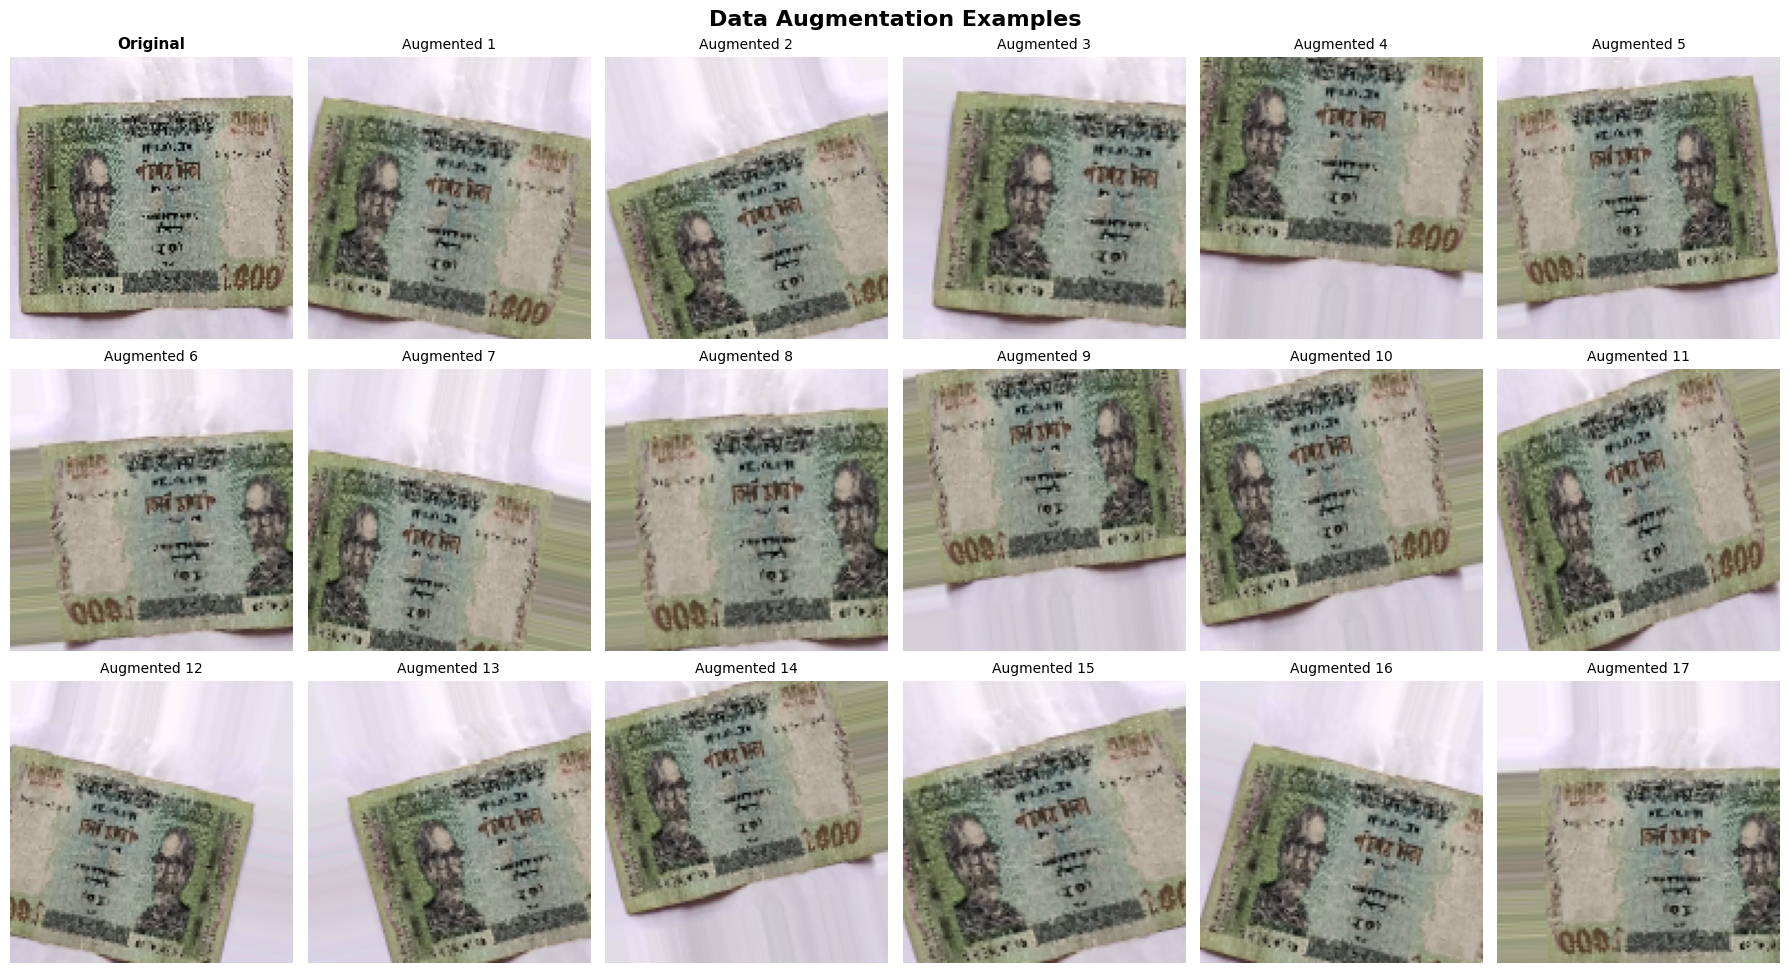

In [56]:
fig, axes = plt.subplots(3, 6, figsize=(18, 10))

sample_img = X_train[0:1]
sample_img_expanded = np.expand_dims(sample_img[0], axis=0)

axes[0, 0].imshow(sample_img[0])
axes[0, 0].set_title('Original', fontsize=11, fontweight='bold')
axes[0, 0].axis('off')

aug_iter = train_datagen.flow(sample_img_expanded, batch_size=1)

for i in range(1, 18):
    augmented_img = next(aug_iter)[0]
    row = i // 6
    col = i % 6
    axes[row, col].imshow(augmented_img)
    axes[row, col].set_title(f'Augmented {i}', fontsize=10)
    axes[row, col].axis('off')

plt.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()